In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio

# Get the Satellite and LIDAR data

In [3]:
satellite = cv2.imread('../data/20230215-SE2B-CGG-GBR-MS3-L3-RGB-preview.jpg', cv2.IMREAD_COLOR)
satellite = cv2.cvtColor(satellite, cv2.COLOR_BGR2RGB)

In [4]:
with rasterio.open("../data/DSM_TQ0075_P_12757_20230109_20230315.tif") as src:
    lidar = src.read(1)

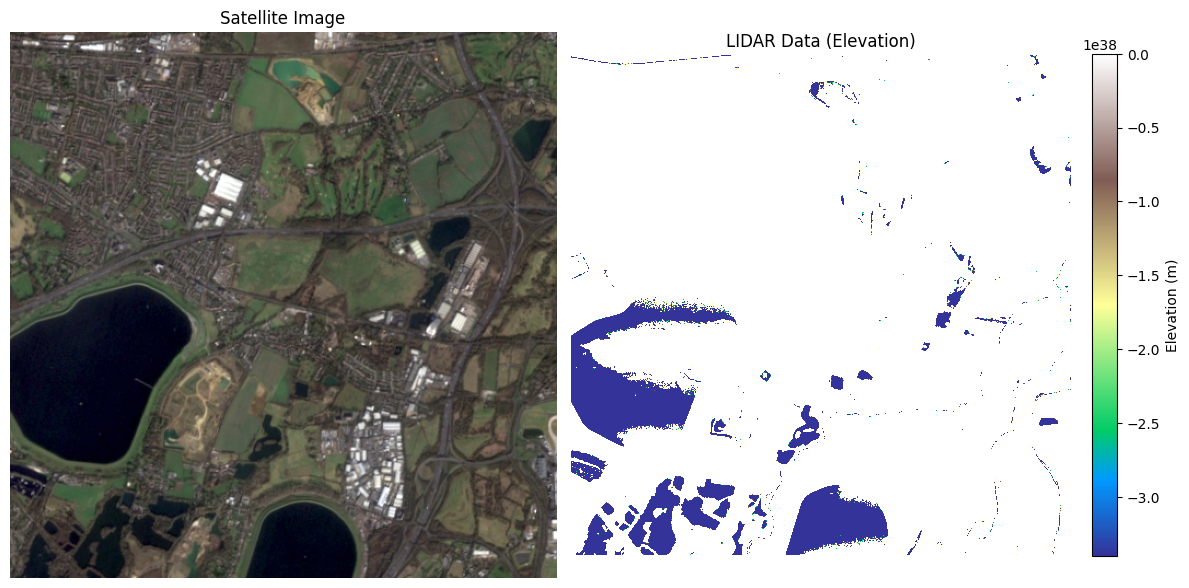

In [5]:
# Resize the LIDAR data to match the satellite image dimensions
lidar_resized = cv2.resize(lidar, (satellite.shape[1], satellite.shape[0]))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the satellite image
axes[0].imshow(satellite)
axes[0].set_title('Satellite Image')
axes[0].axis('off')

# Plot the LIDAR data as a heatmap
im = axes[1].imshow(lidar_resized, cmap='terrain')
axes[1].set_title('LIDAR Data (Elevation)')
axes[1].axis('off')

# Add a colorbar to the LIDAR plot
cbar = fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label('Elevation (m)')

plt.tight_layout()
plt.show()

/tmp/ipykernel_635417/1016939836.py:1: RuntimeWarning: invalid value encountered in log2
  log_lidar = np.log2(lidar)


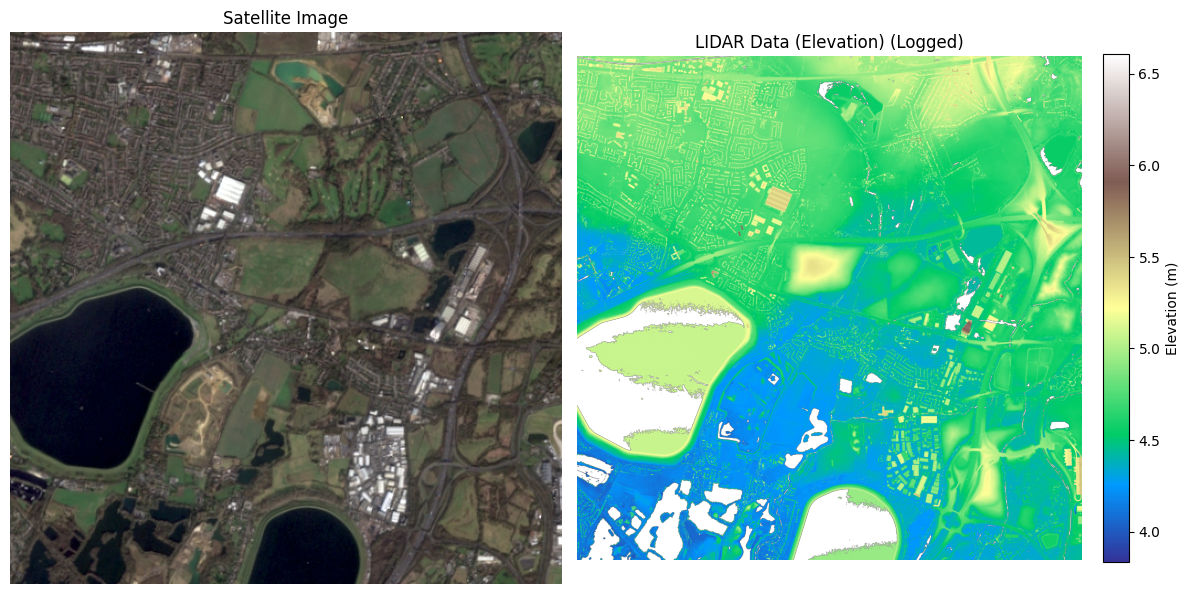

In [6]:
log_lidar = np.log2(lidar)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the satellite image
axes[0].imshow(satellite)
axes[0].set_title('Satellite Image')
axes[0].axis('off')

# Plot the LIDAR data as a heatmap
im = axes[1].imshow(log_lidar, cmap='terrain')
axes[1].set_title('LIDAR Data (Elevation) (Logged)')
axes[1].axis('off')

# Add a colorbar to the LIDAR plot
cbar = fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label('Elevation (m)')

plt.tight_layout()
plt.show()

# Classifying the land types
We will try to classify the following land types:
- Low Density Residential
- Medium Density Residential
- High Density Residential
- Commercial
- Industrial
- Industrial Facilities
- Rural and Agricultural Conservative Zone
- Rural and Agricultural
- Historial Protection Zone
- Military Zone
- Government Institutions

# Lakes
We will attempt to classify the bodies of water in the area.

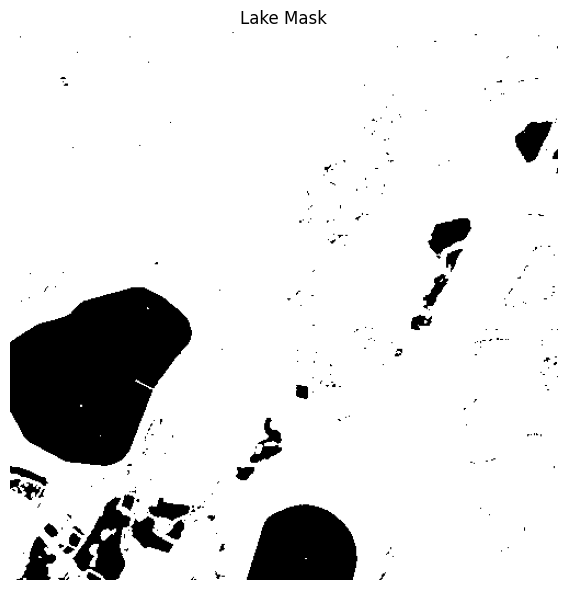

In [7]:
lake_threshold = np.percentile(satellite, 12) # Lakes appear darker than basically anything else on the map, so making a simple mask based on the 12th percentile of pixel values will allow us to identify lakes
lake_mask = satellite.copy()
mask = np.any(satellite < lake_threshold, axis=2)
lake_mask[mask] = 0
lake_mask[~mask] = 255
# Create a figure with two subplots
fig, axes = plt.subplots(figsize=(12, 6))

# Plot the lake mask
axes.imshow(lake_mask, cmap='gray')
axes.set_title('Lake Mask')
axes.axis('off')

plt.tight_layout()
plt.show()

## Residential
We will create a function that maps each pixel to residential density. We can use this to determine 3 ranges for low, medium and high density residential areas.

First, we remove all the lakes and greenery

In [8]:
# Read the NRG image using OpenCV
nrg_img = cv2.imread("../data/20230215-SE2B-CGG-GBR-MS3-L3-NRG-preview.jpg", cv2.IMREAD_COLOR)

# Split the NRG image into its respective bands
nir_band = nrg_img[:, :, 0].astype(float)  # Near-Infrared band
red_band = nrg_img[:, :, 2].astype(float)  # Red band

# Subtract the bands
band_difference = nir_band - red_band

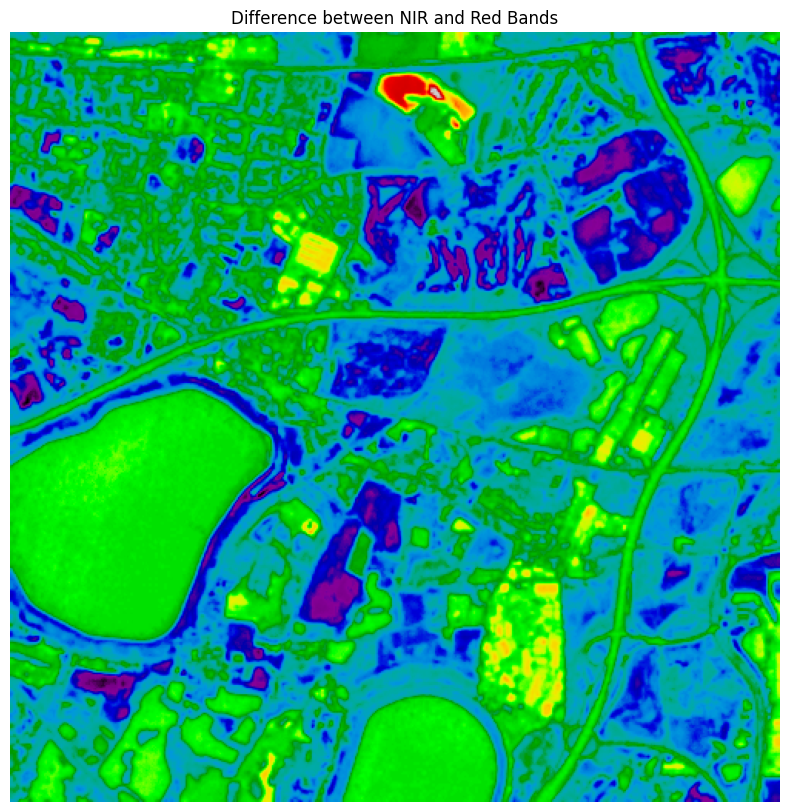

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(band_difference, cmap='nipy_spectral')
ax.set_title('Difference between NIR and Red Bands')
ax.axis('off')

plt.show()

In [10]:
# Define a threshold for the band difference to identify greenery
greenery_threshold = -50

# Create a mask for areas that are not greenery
non_greenery_mask = band_difference > greenery_threshold

# Resize the mask to match the shape of above_ground_lidar_data
non_greenery_mask_resized = cv2.resize(non_greenery_mask.astype(np.uint8), (log_lidar.shape[1], log_lidar.shape[0]), interpolation=cv2.INTER_NEAREST).astype(bool)

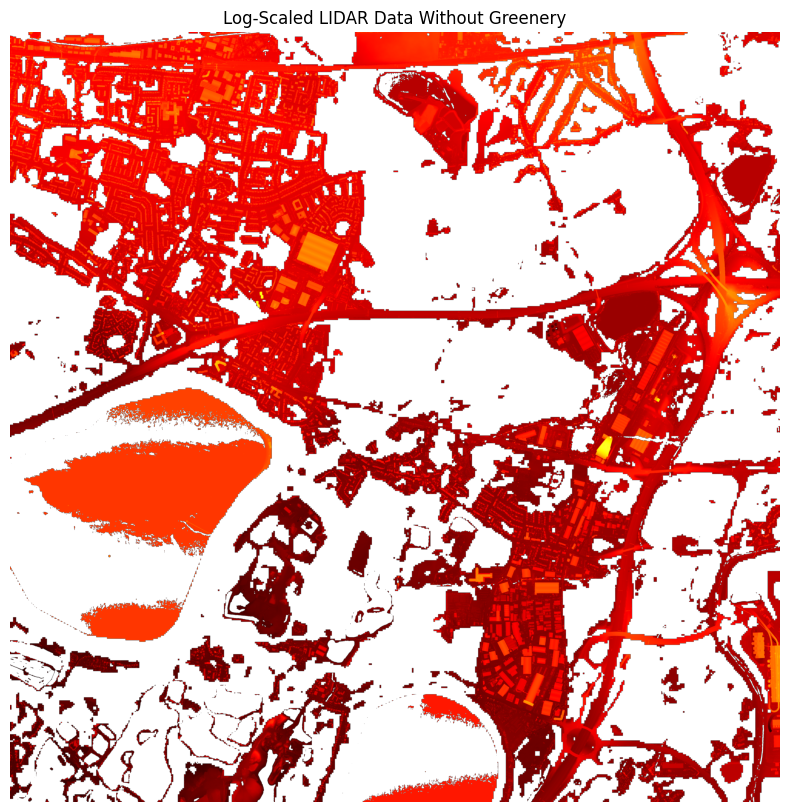

In [11]:
# Apply the resized mask to the log-scaled LIDAR data
log_lidar_data_no_greenery = np.where(non_greenery_mask_resized, log_lidar, np.nan)

# Plot the filtered log-scaled LIDAR data without greenery
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(log_lidar_data_no_greenery, cmap='hot')
ax.set_title('Log-Scaled LIDAR Data Without Greenery')
ax.axis('off')

plt.show()

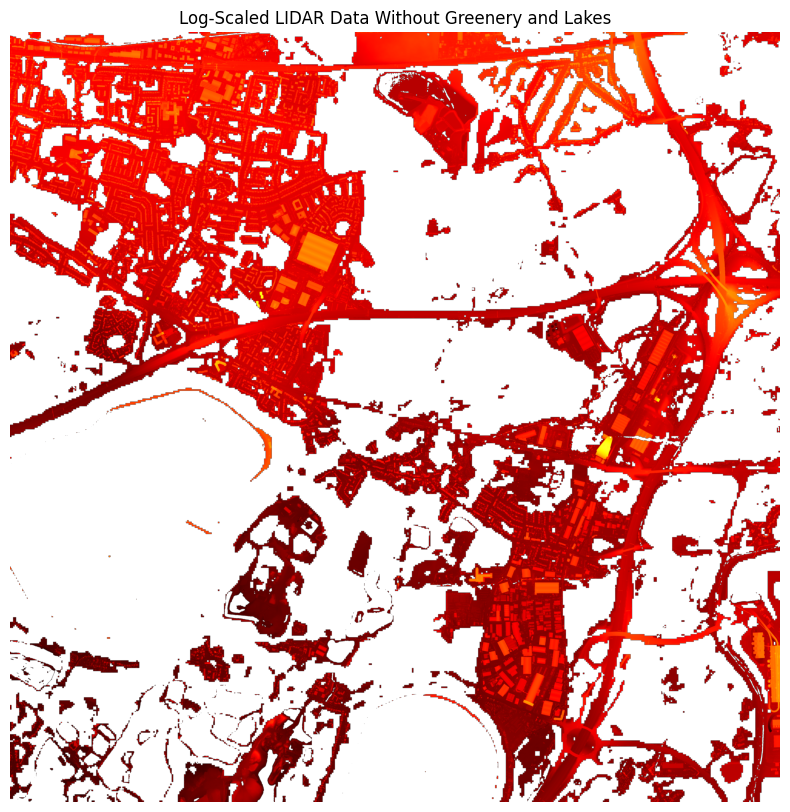

In [12]:
# Create a binary mask from lake_mask (1 where there are features, 0 where there are lakes)
binary_mask = np.any(lake_mask > 0, axis=2)  # Convert RGB mask to binary mask

# Resize binary mask to match lidar data dimensions
lake_mask_resized = cv2.resize(binary_mask.astype(np.uint8), 
							  (log_lidar_data_no_greenery.shape[1], log_lidar_data_no_greenery.shape[0]), 
							  interpolation=cv2.INTER_NEAREST).astype(bool)

# Apply the resized mask to the lidar data
log_lidar_data_no_greenery_no_lake = np.where(lake_mask_resized, log_lidar_data_no_greenery, np.nan)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(log_lidar_data_no_greenery_no_lake, cmap='hot')
ax.set_title('Log-Scaled LIDAR Data Without Greenery and Lakes')
ax.axis('off')
plt.show()

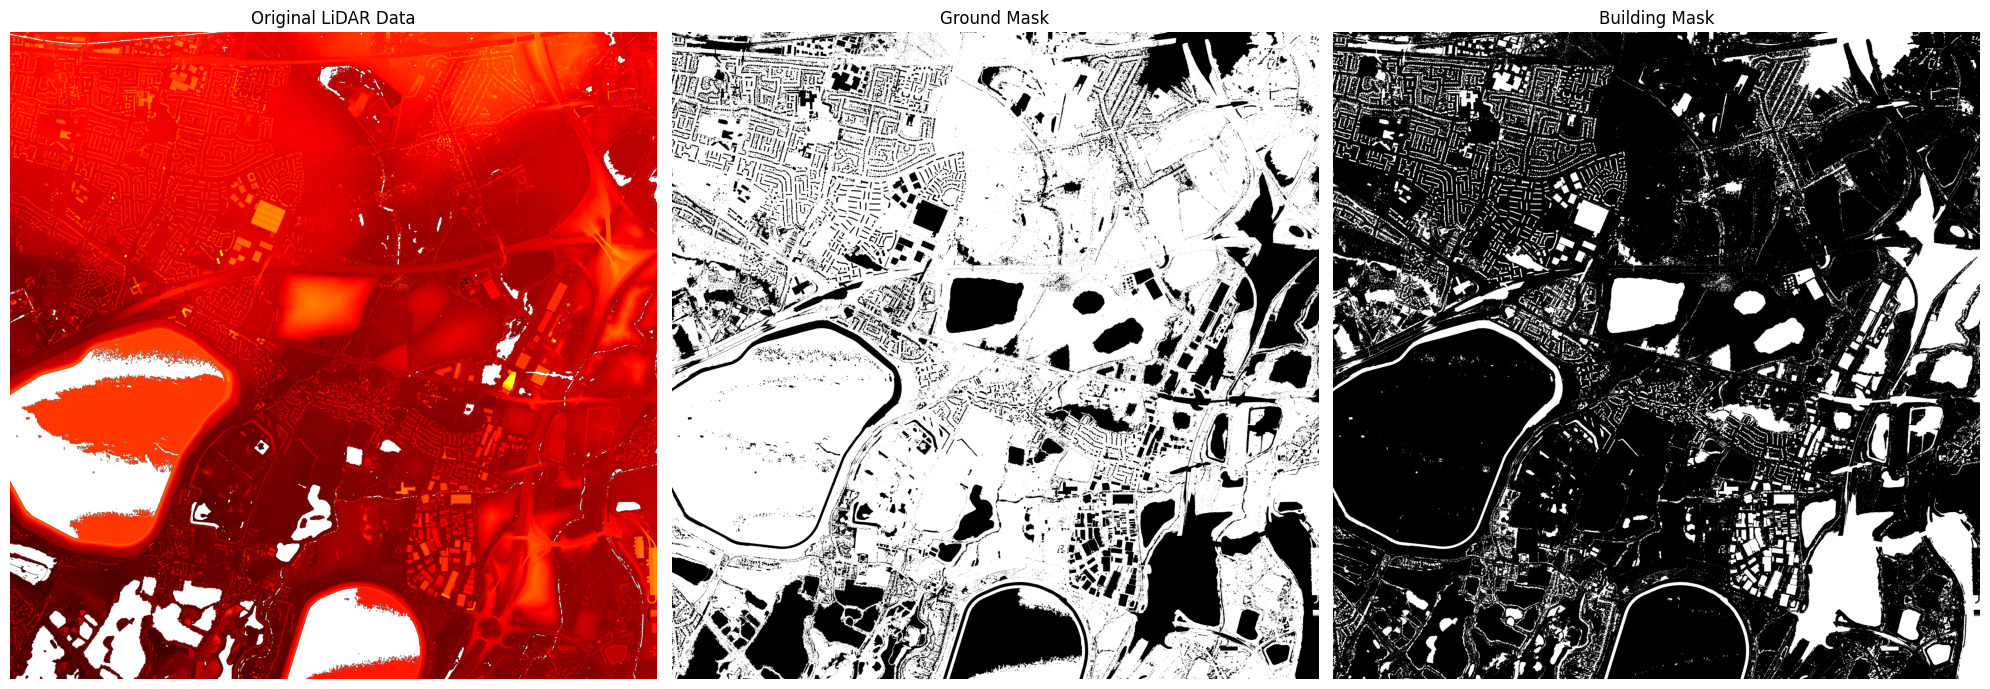

In [13]:
# Create a normalized 8-bit image for floodfill operations
# Replace NaN values with 0
floodfill_img = np.copy(log_lidar)
floodfill_img = np.nan_to_num(floodfill_img, nan=0).astype(np.float32)

# Scale to 0-255 for better visualization and processing
min_val_ff = np.min(floodfill_img)
max_val_ff = np.max(floodfill_img)
floodfill_img = ((floodfill_img - min_val_ff) / (max_val_ff - min_val_ff) * 255).astype(np.uint8)

# Create mask of valid data points (non-NaN areas in original data)
valid_area_mask = ~np.isnan(log_lidar)

# Create a mask for floodfill operation (must be larger than image by 2 pixels in each dimension)
h, w = floodfill_img.shape
flood_mask = np.zeros((h+2, w+2), dtype=np.uint8)

# Create output mask 
building_mask = np.zeros_like(floodfill_img)

# Set seed points along the edges for floodfill (assuming edges are non-buildings)
# We'll use multiple seed points around the perimeter
seed_points = []
step = 500  # Distance between seed points

# Add seed points at the edges
for i in range(0, w, step):
    seed_points.append((0, i))       # Top edge
    seed_points.append((h-1, i))     # Bottom edge
    
for i in range(0, h, step):
    seed_points.append((i, 0))       # Left edge
    seed_points.append((i, w-1))     # Right edge

# Set floodfill parameters
flood_diff = 5  # Tolerance for pixel difference in floodfill

# Apply floodfill from each seed point
for pt in seed_points:
    if valid_area_mask[pt]:  # Only use seed points in valid areas
        # Use floodfill to mark non-building areas
        cv2.floodFill(floodfill_img, flood_mask, pt, 255, 
                      loDiff=flood_diff, upDiff=flood_diff, 
                      flags=cv2.FLOODFILL_FIXED_RANGE)

# Invert to get building mask (buildings=255, non-buildings=0)
ground_mask = (floodfill_img == 255).astype(np.uint8) * 255
building_mask = 255 - ground_mask

# Apply to original valid data only
building_mask = building_mask * valid_area_mask.astype(np.uint8)

# Visualize the results
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

axes[0].imshow(log_lidar, cmap='hot')
axes[0].set_title('Original LiDAR Data')
axes[0].axis('off')

axes[1].imshow(ground_mask, cmap='gray')
axes[1].set_title('Ground Mask')
axes[1].axis('off')

axes[2].imshow(building_mask, cmap='gray')
axes[2].set_title('Building Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()

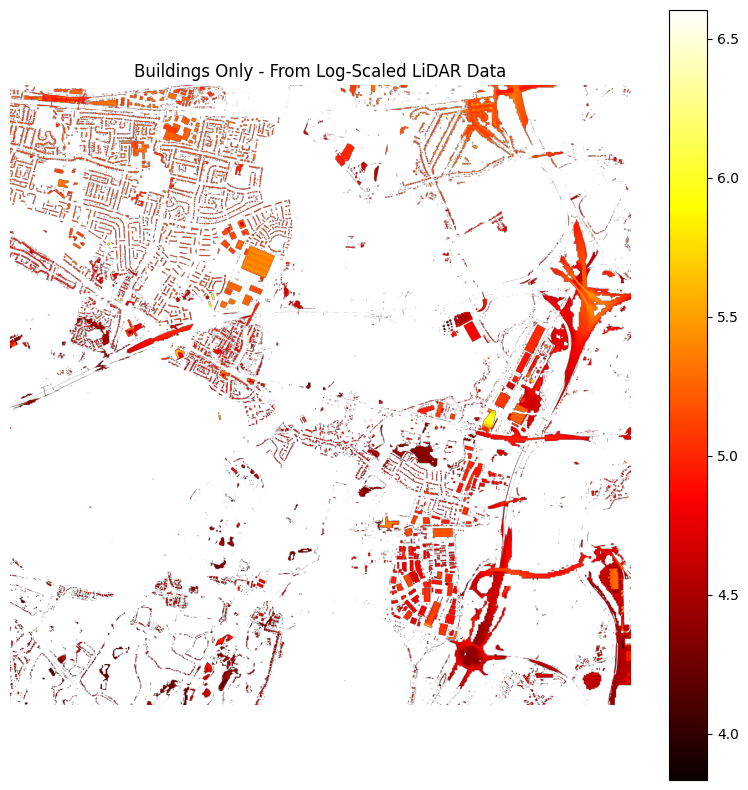

Number of building pixels identified: 2883773
Mean building height (log scale): 4.8547
Min building height (log scale): 3.8345
Max building height (log scale): 6.6026


In [ ]:
# Convert building_mask to boolean (True where buildings exist)
building_bool_mask = (building_mask == 255)

# Apply the building mask to the processed LiDAR data to extract only buildings
buildings_lidar_data = np.where(building_bool_mask, log_lidar_data_no_greenery_no_lake, np.nan)

# Visualize the buildings-only LiDAR data
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(buildings_lidar_data, cmap='hot')
ax.set_title('Buildings Only - From Log-Scaled LiDAR Data')
ax.axis('off')
plt.colorbar(im)
plt.show()

# Print some statistics about the buildings
valid_building_data = buildings_lidar_data[~np.isnan(buildings_lidar_data)]
if len(valid_building_data) > 0:
    print(f"Number of building pixels identified: {len(valid_building_data)}")
    print(f"Mean building height (log scale): {np.mean(valid_building_data):.4f}")
    print(f"Min building height (log scale): {np.min(valid_building_data):.4f}")
    print(f"Max building height (log scale): {np.max(valid_building_data):.4f}")
else:
    print("No building pixels were identified.")

Starting connected components analysis...
Finished connected components. starting filtering...
Total components: 38133


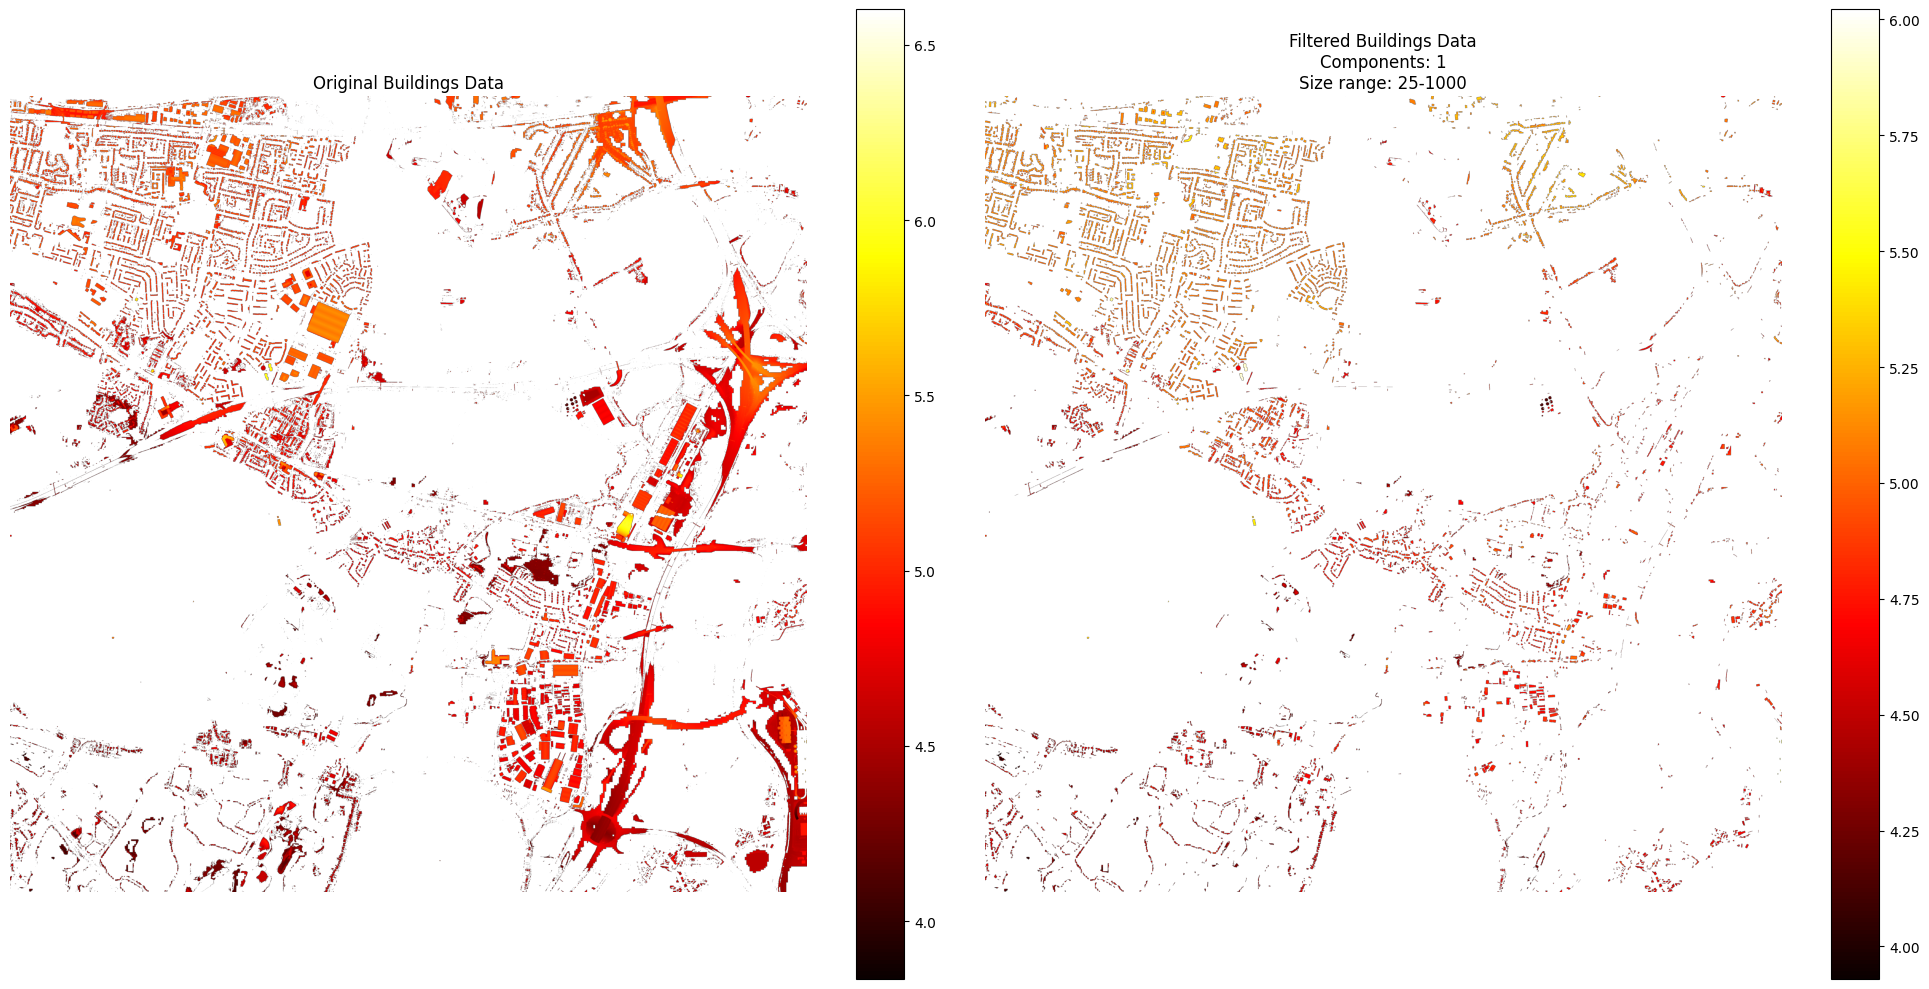

Total components: 38132
Min component size: 1
Max component size: 218679
Mean component size: 75.6
Components kept after filtering: 35.2%


In [17]:
# Convert buildings_lidar_data to a binary mask (1 where there's valid building data, 0 elsewhere)
binary_building_mask = ~np.isnan(buildings_lidar_data)
binary_building_mask = binary_building_mask.astype(np.uint8)

print("Starting connected components analysis...")
# Apply connected components analysis
min_size = 25  # Minimum size of buildings to keep
max_size = 1000  # Maximum size of buildings (remove larger components)
num_labels, labels_im = cv2.connectedComponents(binary_building_mask)

print("Finished connected components. starting filtering...")
# Filter components based on size
filtered_building_mask = np.zeros_like(binary_building_mask)
sizes = []
print(f"Total components: {num_labels}")
for label in range(1, num_labels):
    print(f"Processing component {label}/{num_labels}...", end='\r')
    label_mask = labels_im == label
    label_size = np.sum(label_mask)
    sizes.append(label_size)
    if min_size <= label_size <= max_size:
        filtered_building_mask[label_mask] = 1

# Apply the filtered mask to the original data
filtered_buildings_lidar_data = np.where(filtered_building_mask == 1, buildings_lidar_data, np.nan)

# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Original buildings data
im1 = axes[0].imshow(buildings_lidar_data, cmap='hot')
axes[0].set_title('Original Buildings Data')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])

# Filtered buildings data
im2 = axes[1].imshow(filtered_buildings_lidar_data, cmap='hot')
axes[1].set_title(f'Filtered Buildings Data\nComponents: {np.max(filtered_building_mask)}\nSize range: {min_size}-{max_size}')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

# Print statistics about the components
if sizes:
    print(f"Total components: {len(sizes)}")
    print(f"Min component size: {min(sizes)}")
    print(f"Max component size: {max(sizes)}")
    print(f"Mean component size: {np.mean(sizes):.1f}")
    print(f"Components kept after filtering: {np.sum(filtered_building_mask > 0) / np.sum(binary_building_mask > 0):.1%}")

In [ ]:
from scipy.ndimage import convolve

# Create a density map using the filtered building mask

# Define kernel size for the neighborhood analysis
kernel_size = 100
kernel = np.ones((kernel_size, kernel_size))

# Perform convolution to count nearby building pixels
print("Starting convolution...")
building_density = convolve(filtered_building_mask.astype(float), kernel, mode='constant', cval=0.0)
print("Convolution completed.")

# Visualize the building density
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(building_density, cmap='hot')
ax.set_title(f'Building Density (Kernel Size: {kernel_size}x{kernel_size})')
ax.axis('off')
plt.colorbar(im, label='Building density score')
plt.show()

# Define thresholds for residential density classification
non_zero_density = building_density[building_density > 0]
if len(non_zero_density) > 0:
    low_threshold = np.percentile(non_zero_density, 33)
    medium_threshold = np.percentile(non_zero_density, 67)
    
    # Create residential density classification map
    residential_map = np.zeros_like(building_density, dtype=np.uint8)
    residential_map[(building_density > 0) & (building_density <= low_threshold)] = 1  # Low density
    residential_map[(building_density > low_threshold) & (building_density <= medium_threshold)] = 2  # Medium density
    residential_map[building_density > medium_threshold] = 3  # High density
    
    # Visualize the classification
    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = plt.cm.get_cmap('viridis', 4)
    im = ax.imshow(residential_map, cmap=cmap, vmin=0, vmax=3)
    ax.set_title('Residential Density Classification')
    ax.axis('off')
    cbar = plt.colorbar(im, ticks=[0, 1, 2, 3], fraction=0.046, pad=0.04)
    cbar.set_ticklabels(['Non-residential', 'Low Density', 'Medium Density', 'High Density'])
    
    # Print statistics
    print(f"Low Density Threshold: {low_threshold:.1f}")
    print(f"Medium Density Threshold: {medium_threshold:.1f}")
    print(f"Building pixels classified as Low Density: {np.sum(residential_map == 1):,}")
    print(f"Building pixels classified as Medium Density: {np.sum(residential_map == 2):,}")
    print(f"Building pixels classified as High Density: {np.sum(residential_map == 3):,}")
else:
    print("No buildings detected in the filtered mask.")

Starting convolution...
Convolution completed.
